In [2]:
import numpy as np
import pickle
from itertools import combinations
import matplotlib.pyplot as plt
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from utils.util import *
from dataset import get_loaders

In [3]:
analyze_name = 'analyze_regression'

In [4]:
with open('../../results/%s_results_mlp.P' %(analyze_name), 'rb') as f:
    mlp_results = pickle.load(f)
# ----------------------
lesion_p = 0.1
# ----------------------
ctx_order = 'first'
ctx_order_str = 'ctxF'
# ----------------------
with open('../../results/%s_%s_results_rnn_init1.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnn_results_ctxF = pickle.load(f)

with open('../../results/%s_%s_results_rnn_lesionp%s.P' %(analyze_name, ctx_order_str, lesion_p), 'rb') as f:
    rnnlesion_results_ctxF = pickle.load(f)

with open('../../results/%s_%s_results_rnncell_init1.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnncell_results_ctxF = pickle.load(f)

with open('../../results/%s_%s_results_rnn_balanced.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnnb_results_ctxF = pickle.load(f)
# ----------------------
ctx_order = 'last'
ctx_order_str = 'ctxL'
# ----------------------
with open('../../results/%s_%s_results_rnn_init1.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnn_results_ctxL = pickle.load(f)

with open('../../results/%s_%s_results_rnn_lesionp%s.P' %(analyze_name, ctx_order_str, lesion_p), 'rb') as f:
    rnnlesion_results_ctxL = pickle.load(f)

with open('../../results/%s_%s_results_rnncell_init1.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnncell_results_ctxL = pickle.load(f)

with open('../../results/%s_%s_results_rnn_balanced.P' %(analyze_name, ctx_order_str), 'rb') as f:
    rnnb_results_ctxL = pickle.load(f)
# ----------------------
with open('../../results/%s_results_stepwisemlp.P' %(analyze_name), 'rb') as f:
    swmlp_results = pickle.load(f)

with open('../../results/%s_results_truncated_stepwisemlp.P' %(analyze_name), 'rb') as f:
    swmlp_trunc_results = pickle.load(f)
# ----------------------
with open('../../results/%s_results_mlp_cc.P' %(analyze_name), 'rb') as f:
    mlpcc_results = pickle.load(f)

In [5]:
mlp_runs             = dict_to_list(mlp_results, analyze_name)
rnn_runs_ctxF        = dict_to_list(rnn_results_ctxF, analyze_name)
rnncell_runs_ctxF    = dict_to_list(rnncell_results_ctxF, analyze_name)
rnnb_runs_ctxF       = dict_to_list(rnnb_results_ctxF, analyze_name)
rnnlesion_runs_ctxF = dict_to_list(rnnlesion_results_ctxF, analyze_name)
rnn_runs_ctxL        = dict_to_list(rnn_results_ctxL, analyze_name)
rnncell_runs_ctxL    = dict_to_list(rnncell_results_ctxL, analyze_name)
rnnb_runs_ctxL       = dict_to_list(rnnb_results_ctxL, analyze_name)
rnnlesion_runs_ctxL = dict_to_list(rnnlesion_results_ctxL, analyze_name)
swmlp_runs           = dict_to_list(swmlp_results, analyze_name)
mlpcc_runs           = dict_to_list(mlpcc_results, analyze_name)
mlp_runs.keys()

dict_keys(['cat_reg', 'con_reg'])

In [6]:
reg_analyze_name = 'cat_reg'
mlp_cat_runs            = dict_to_list(mlp_runs, reg_analyze_name)
rnn_cat_runs_ctxF       = dict_to_list(rnn_runs_ctxF, reg_analyze_name)
rnncell_cat_runs_ctxF   = dict_to_list(rnncell_runs_ctxF, reg_analyze_name)
rnnb_cat_runs_ctxF      = dict_to_list(rnnb_runs_ctxF, reg_analyze_name)
rnnlesion_cat_runs_ctxF = dict_to_list(rnnlesion_runs_ctxF, reg_analyze_name)
rnn_cat_runs_ctxL       = dict_to_list(rnn_runs_ctxL, reg_analyze_name)
rnncell_cat_runs_ctxL   = dict_to_list(rnncell_runs_ctxL, reg_analyze_name)
rnnb_cat_runs_ctxL      = dict_to_list(rnnb_runs_ctxL, reg_analyze_name)
rnnlesion_cat_runs_ctxL = dict_to_list(rnnlesion_runs_ctxL, reg_analyze_name)
swmlp_cat_runs          = dict_to_list(swmlp_runs, reg_analyze_name)
mlpcc_cat_runs          = dict_to_list(mlpcc_runs, reg_analyze_name)
mlp_cat_runs.keys()

dict_keys(['p_val', 't_val', 'param', 'y_hat_E', 'y', 'bse'])

In [8]:
data = get_loaders(batch_size=32, meta=False,
                    use_images=True, image_dir='../images/',
                    n_episodes=None, N_responses=None, N_contexts=None,
                    cortical_task='face_task', balanced=False)
train_data, train_loader, test_data, test_loader, analyze_data, analyze_loader = data

In [9]:
y_hat_Es = mlp_cat_runs['y_hat_E'] # [runs, checkpoints, n_combinations]: [20, 21, 120]
ys = mlp_cat_runs['y'] 
np.asarray(y_hat_Es).shape

(20, 21, 120)

In [10]:
def calc_rsa_dis(results, test_data):
    y_hat_Es = np.asarray(results['y_hat_E']) # [runs, checkpoints, n_combinations]: [20, 21, 120]
    ys = np.asarray(results['y'])
    cp = -1
    n_states = test_data.n_states 
    loc2idx = test_data.loc2idx 
    idxs = [idx for idx in range(n_states)]
    locs = [loc for loc, idx in loc2idx.items()]
    wE = ys - y_hat_Es
    wE = wE.mean(axis=0)[cp]
    print(wE.shape)
    rsa_dist = np.zeros(shape=(n_states, n_states))
    for i, (idx1, idx2) in enumerate(combinations(idxs, 2)):
        rsa_dist[idx1][idx2] = wE[i]
        rsa_dist[idx2][idx1] = wE[i]
    return rsa_dist


In [ ]:
# reg_analyze_name = 'cat_reg'
# mlp_cat_runs          = dict_to_list(mlp_runs, reg_analyze_name)
# rnn_cat_runs_ctxF     = dict_to_list(rnn_runs_ctxF, reg_analyze_name)
# rnncell_cat_runs_ctxF = dict_to_list(rnncell_runs_ctxF, reg_analyze_name)
# rnnb_cat_runs_ctxF     = dict_to_list(rnnb_runs_ctxF, reg_analyze_name)
# rnn_cat_runs_ctxL     = dict_to_list(rnn_runs_ctxL, reg_analyze_name)
# rnncell_cat_runs_ctxL = dict_to_list(rnncell_runs_ctxL, reg_analyze_name)
# rnnb_cat_runs_ctxL     = dict_to_list(rnnb_runs_ctxL, reg_analyze_name)
# swmlp_cat_runs        = dict_to_list(swmlp_runs, reg_analyze_name)
# mlpcc_cat_runs        = dict_to_list(mlpcc_runs, reg_analyze_name)
# mlp_cat_runs.keys()

In [13]:
rsa_dist_mlp            = calc_rsa_dis(mlp_cat_runs, test_data)
rsa_dist_rnn_ctxF       = calc_rsa_dis(rnn_cat_runs_ctxF, test_data)
rsa_dist_rnncell_ctxF   = calc_rsa_dis(rnncell_cat_runs_ctxF, test_data)
rsa_dist_rnnb_ctxF      = calc_rsa_dis(rnnb_cat_runs_ctxF, test_data)
rsa_dist_rnnlesion_ctxF = calc_rsa_dis(rnnlesion_cat_runs_ctxF, test_data)

rsa_dist_rnn_ctxL       = calc_rsa_dis(rnn_cat_runs_ctxL, test_data)
rsa_dist_rnncell_ctxL   = calc_rsa_dis(rnncell_cat_runs_ctxL, test_data)
rsa_dist_rnnb_ctxL      = calc_rsa_dis(rnnb_cat_runs_ctxL, test_data)
rsa_dist_rnnlesion_ctxL = calc_rsa_dis(rnnlesion_cat_runs_ctxL, test_data)

# rsa_dist_swmlp_hidd1   = calc_rsa_dis(swmlp_cat_runs[:,0], test_data)
# rsa_dist_swmlp_hidd2   = calc_rsa_dis(swmlp_cat_runs[:,1], test_data)
rsa_dist_mlpcc   = calc_rsa_dis(mlpcc_cat_runs, test_data)

(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)
(120,)


In [92]:
# y_hat_Es = np.asarray(swmlp_cat_runs['y_hat_E']) # [runs, checkpoints, n_combinations]: [20, 21, 120]
# ys = np.asarray(swmlp_cat_runs['y'])
# y_hat_Es.shape


(20, 21, 120, 2)

### preprating stepwise mlp separately

In [14]:
y_hat_Es = np.asarray(swmlp_cat_runs['y_hat_E']) # [runs, checkpoints, n_combinations]: [20, 21, 120]
ys = np.asarray(swmlp_cat_runs['y'])

runs, checkpoints, n_combinations, n_hidds = y_hat_Es.shape
ys_swmlp = np.zeros([runs, checkpoints, n_combinations, n_hidds])
yhats_swmlp = np.zeros([runs, checkpoints, n_combinations, n_hidds])
for r in range(runs):
    for cp in range(checkpoints):
        yhats_swmlp[r,cp,:,:] = y_hat_Es[r,cp]
        ys_swmlp[r,cp,:,:] = ys[r,cp]
cp = -1
n_states = test_data.n_states 
loc2idx = test_data.loc2idx 
idxs = [idx for idx in range(n_states)]
locs = [loc for loc, idx in loc2idx.items()]
wE = ys_swmlp - yhats_swmlp
wE = wE.mean(axis=0)[cp]
rsa_dist_swmlp = np.zeros(shape=(n_states, n_states, n_hidds))
for i, (idx1, idx2) in enumerate(combinations(idxs, 2)):
    for h in range(n_hidds):
        rsa_dist_swmlp[idx1,idx2,h] = wE[i,h]
        rsa_dist_swmlp[idx2,idx1,h] = wE[i,h]
print(rsa_dist_swmlp.shape)

(16, 16, 2)


In [32]:
def plot_rsa(ctx_order, val_res, model_str, mfig_str):
    fig, axs = plt.subplots()
    plt.imshow(val_res, vmin=vmin, vmax=vmax)
    plt.xticks(idxs, locs, rotation='90')
    plt.yticks(idxs, locs)
    plt.colorbar()
    
    if ctx_order is not None:
        fig.suptitle('RSA Results - %s - Ax %s' %(model_str, ctx_order), fontweight='bold', fontsize='25')
    else:
        fig.suptitle('RSA Results - %s' %(model_str), fontweight='bold', fontsize='25')
    
    plt.tight_layout()

    fig_str = '%s_rsa_results_%s' %(ctx_order_str, mfig_str)

    fig.savefig(('../../figures/' + fig_str + '.pdf'),
                bbox_inches = 'tight', pad_inches=0)
    fig.savefig(('../../figures/' + fig_str + '.png'),
                bbox_inches = 'tight', pad_inches=0)

# RNN

In [18]:
vmin, vmax = -2.5, 2.5

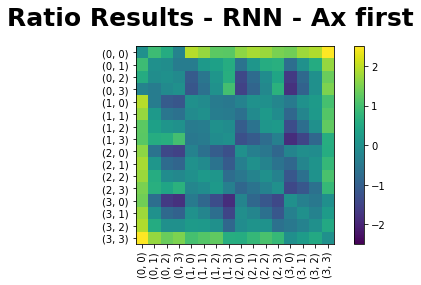

In [21]:
plot_rsa('first', rsa_dist_rnn_ctxF, 'RNN', 'rnn')

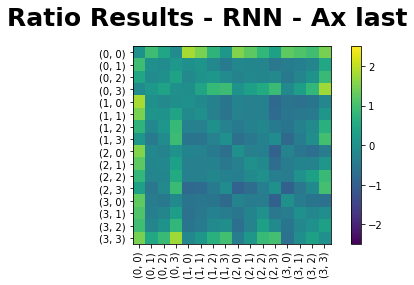

In [22]:
plot_rsa('last', rsa_dist_rnn_ctxL, 'RNN', 'rnn')

# Balanced RNN

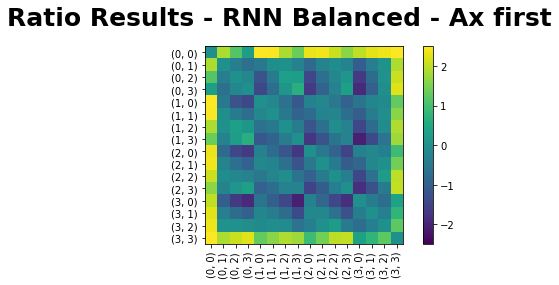

In [23]:
plot_rsa('first', rsa_dist_rnnb_ctxF, 'RNN Balanced', 'rnnbalanced')

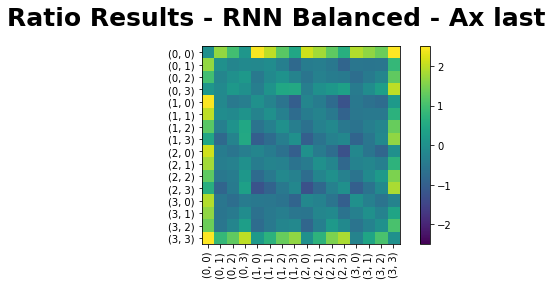

In [24]:
plot_rsa('last', rsa_dist_rnnb_ctxL, 'RNN Balanced', 'rnnbalanced')

# RNNCell

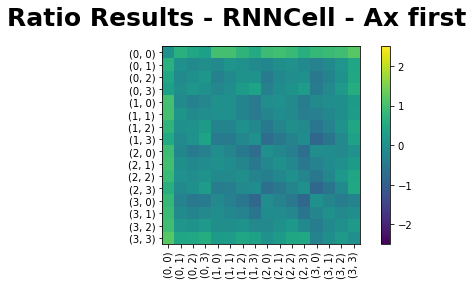

In [30]:
plot_rsa('first', rsa_dist_rnncell_ctxF, 'RNNCell', 'rnncell')

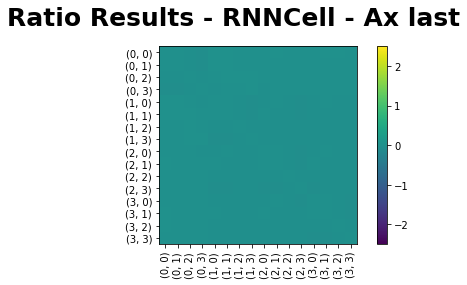

In [31]:
plot_rsa('last', rsa_dist_rnncell_ctxL, 'RNNCell', 'rnncell')

# MLP

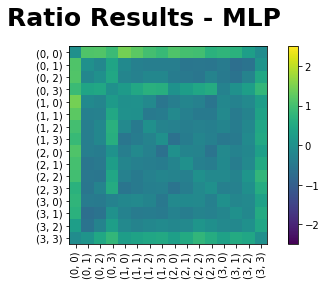

In [25]:
plot_rsa(None, rsa_dist_mlp, 'MLP', 'mlp')

# Cognitive Controller

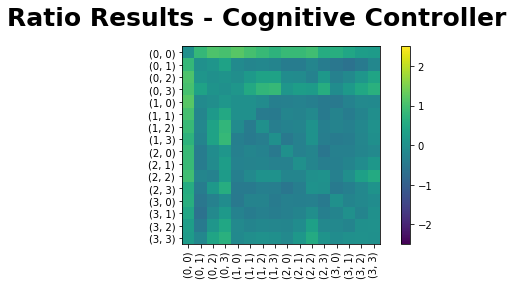

In [26]:
plot_rsa(None, rsa_dist_mlpcc, 'Cognitive Controller', 'mlpcc')

# Stepwise MLP

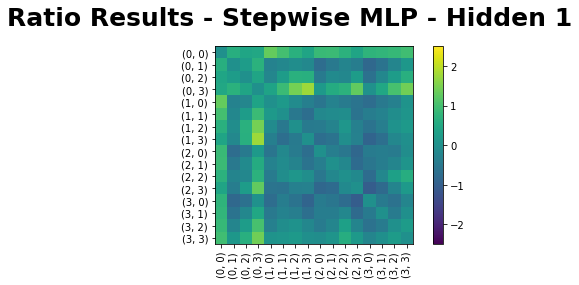

In [28]:
plot_rsa(None, rsa_dist_swmlp[:,:,0], 'Stepwise MLP - Hidden 1', 'rsa_swmlp_hidd1')

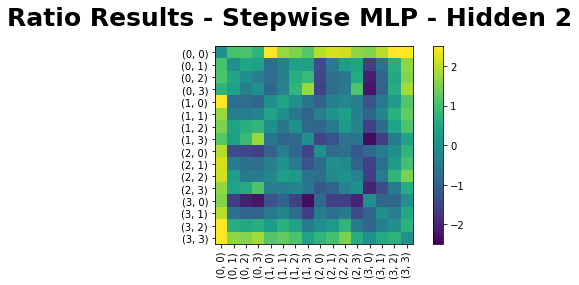

In [29]:
plot_rsa(None, rsa_dist_swmlp[:,:,1], 'Stepwise MLP - Hidden 2', 'rsa_swmlp_hidd1')